In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
from google.colab.patches import cv2_imshow
import re
from bs4 import BeautifulSoup #for reading xml file
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS  #for plotting wordcloud
from tqdm import tqdm

In [7]:
image_folder = '/cluster/home/guillera/varun/github_model_data/Images' #path to folder containing images
total_images = len(os.listdir(image_folder))
print('The number of images in data are: %i'%(total_images))

The number of images in data are: 7471


1)



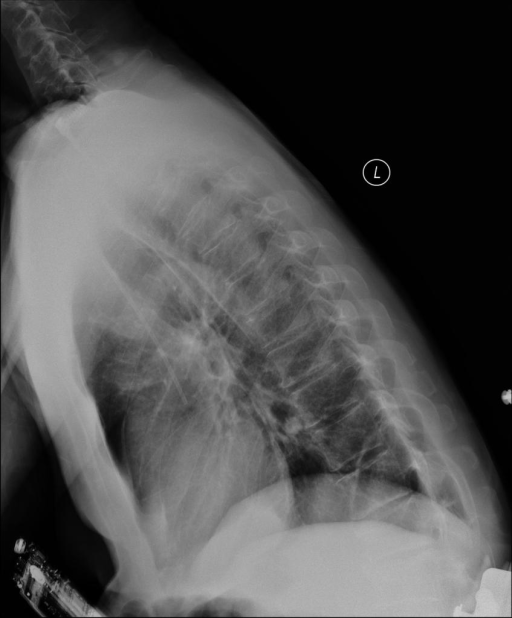

		 CXR2822_IM-1244-0001.png
2)



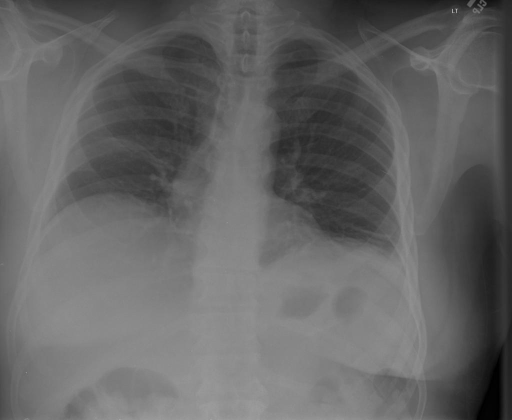

		 CXR3570_IM-1754-3001.png
3)



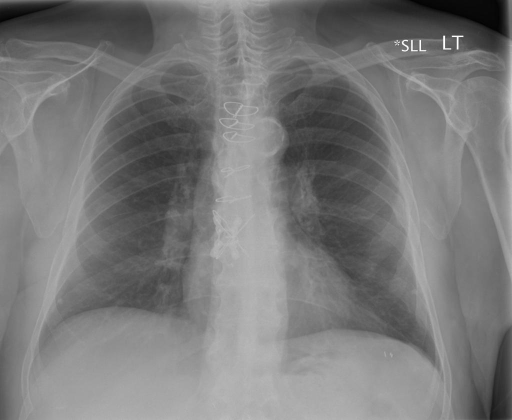

		 CXR1065_IM-0046-1001.png


In [8]:
#showing random 3 sample images
np.random.seed(420)
for i in range(3): #print 5 sample images
  k = np.random.choice(range(total_images))
  image_file = os.listdir(image_folder)[k]
  image = cv2.imread(os.path.join(image_folder,image_file)) #getting an image file
  print("%i)\n"%(i+1))
  cv2_imshow(image)
  print("\t\t",image_file) #the image file name

In [9]:
reports_folder = "/cluster/home/guillera/varun/github_model_data/ecgen-radiology"
total_reports = len(os.listdir(reports_folder))
print('The number of reports in the data are: %i'%(total_reports))

The number of reports in the data are: 3955


In [10]:
no_images = [] #stores the no. of images
for file in os.listdir(reports_folder):
  report_file = os.path.join(reports_folder,file)
  with open(report_file, 'r') as f:  #reading the xml data
    data = f.read()
  regex = r"parentImage id.*" #getting all the image names
  k  = re.findall(regex,data)
  temp = len(k)
  no_images.append(temp)


In [11]:
no_images = np.array(no_images)
print("The max no. of images found associated with a report: %i"%(no_images.max()))
print("The min no. of images found associated with a report: %i"%(no_images.min()))

The max no. of images found associated with a report: 5
The min no. of images found associated with a report: 0


In [12]:
plt.figure(figsize = (6,4))
ax = pd.Series(no_images).plot(kind='hist')
ax.set_xlabel('No. of images associated with report')
ax.set_title("Frequency vs No. of images associated with report")
plt.show()
print("Image Value_counts\n")
print(pd.Series(no_images).value_counts())

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

In [13]:
# function for obtaining the different information part of the xml report file and preprocessing them and also adding the concernced image and report information to the dataframe
def decontracted(phrase): #https://stackoverflow.com/a/47091490
  """
  performs text decontraction of words like won't to will not
  """
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase


def get_info(xml_data,info): #https://regex101.com/
  """
  extracts the information data from the xml file and does text preprocessing on them
  here info can be 1 value in this list ["COMPARISON","INDICATION","FINDINGS","IMPRESSION"]
  """
  regex = r"\""  +info +r"\".*" 
  k = re.findall(regex,xml_data)[0] #finding info part of the report

  regex = r"\>.*\<"
  k = re.findall(regex,k)[0] #removing info string and /AbstractText>'

  regex = r"\d." 
  k = re.sub(regex,"",k) #removing all values like "1." and "2." etc

  regex = r"X+"
  k = re.sub(regex,"",k) #removing words like XXXX

  regex = r" \."
  k = re.sub(regex,"",k) #removing singular fullstop ie " ."

  regex = r"[^.a-zA-Z]" 
  k = re.sub(regex," ",k) #removing all special characters except for full stop

  regex = r"\."
  k = re.sub(regex," .",k) #adding space before fullstop
  k = decontracted(k) #perform decontraction
  k = k.strip().lower() #strips the begining and end of the string of spaces and converts all into lowercase
  k = " ".join(k.split()) #removes unwanted spaces
  if k=="": #if the resulting sentence is an empty string return null value
    k = np.nan
  return k

def get_final(data):
  """
  given an xml data returns "COMPARISON","INDICATION","FINDINGS","IMPRESSION" part of the data
  """
  try: #assigning null values to the ones that don't have the concerned info
      comparison = get_info(data, "COMPARISON")
  except:
    comparison = np.nan;

  try: #assigning null values to the ones that don't have the concerned info
    indication = get_info(data, "INDICATION")
  except:
    indication = np.nan;

  try: #assigning null values to the ones that don't have the concerned info
    finding = get_info(data,"FINDINGS")
  except:
    finding = np.nan;

  try: #assigning null values to the ones that don't have the concerned info
    impression = get_info(data, "IMPRESSION")
  except:
    impression = np.nan;

  return comparison,indication,finding,impression

def get_df():
  """
  Given an xml data, it will extract the two image names and corresponding info text and returns a dataframe
  """
  im1 = [] #there are 2 images associated with a report
  im2 = []
  #stores info
  comparisons = []
  indications = []
  findings = []
  impressions = [] 
  report = [] #stores xml file name
  for file in tqdm(os.listdir(reports_folder)):
    report_file = os.path.join(reports_folder,file)
    with open(report_file, 'r') as f:  #reading the xml data
      data = f.read()
  
    regex = r"parentImage id.*" #getting all the image names
    k  = re.findall(regex,data)

    if len(k)==2: 
      regex = r"\".*\"" #getting the name
      image1 = re.findall(regex,k[0])[0]
      image2 = re.findall(regex,k[1])[0]

      image1 = re.sub(r"\"","",image1)
      image2 = re.sub(r"\"","",image2)

      image1 = image1.strip()+".png"
      image2 = image2.strip()+".png"
      im1.append(image1)
      im2.append(image2)

      comparison,indication,finding,impression = get_final(data)
      comparisons.append(comparison)
      indications.append(indication)
      findings.append(finding)
      impressions.append(impression)
      report.append(file) #xml file name

    
    elif len(k)<2:
      regex = r"\".*\"" #getting the name
      try: #if the exception is raised means no image file name was found
        image1 = re.findall(regex,k[0])[0]
        image1 = re.sub(r"\"","",image1) #removing "
        image2 = np.nan

        image1 = image1.strip()+".png"
      except:
        image1 = np.nan
        image2 = np.nan


      im1.append(image1)
      im2.append(image2)
      comparison,indication,finding,impression = get_final(data)
      comparisons.append(comparison)
      indications.append(indication)
      findings.append(finding)
      impressions.append(impression)
      report.append(file) #xml file name
    
    else: #if there are more than 2 images concerned with report
      comparison,indication,finding,impression = get_final(data)

      for i in range(len(k)-1):
        regex = r"\".*\"" #getting the name
        image1 = re.findall(regex,k[i])[0] #re.findall returns a list
        image2 = re.findall(regex,k[i+1])[0] 

        image1 = re.sub(r"\"","",image1) #removing "
        image2 = re.sub(r"\"","",image2) #removing "

        image1 = image1.strip()+".png"
        image2 = image2.strip()+".png"

        im1.append(image1)
        im2.append(image2)
        comparisons.append(comparison)
        indications.append(indication)
        findings.append(finding)
        impressions.append(impression)
        report.append(file) #xml file name
    
  df = pd.DataFrame({"image_1":im1,"image_2":im2,"comparison":comparisons,"indication":indications,"findings":findings,"impression":impressions,"xml file name":report})
  return df


In [14]:
%%time
df = get_df()

100%|██████████| 3955/3955 [00:01<00:00, 2060.05it/s]

CPU times: user 777 ms, sys: 531 ms, total: 1.31 s
Wall time: 1.93 s


In [18]:
# df.to_pickle("/cluster/home/guillera/varun/medical_captioning/df.pkl")
df = pd.read_pickle("/cluster/home/guillera/varun/medical_captioning/df.pkl")
df.shape

(4169, 7)

In [20]:
from collections import OrderedDict
df.head()

ImportError: cannot import name 'OrderedDict'

                    image_1                   image_2       comparison  \
0  CXR2480_IM-1009-1001.png  CXR2480_IM-1009-2001.png           none .   
1  CXR1525_IM-0340-1001.png  CXR1525_IM-0340-2001.png  none . clinical   
2  CXR1525_IM-0340-2001.png  CXR1525_IM-0340-3001.png  none . clinical   
3  CXR1525_IM-0340-3001.png  CXR1525_IM-0340-4001.png  none . clinical   
4  CXR3976_IM-2035-1001.png  CXR3976_IM-2035-2001.png           none .   

                                          indication  \
0                                       chest pain .   
1                                                  .   
2                                                  .   
3                                                  .   
4  upper back pain hoarseness history of chronic ...   

                                            findings  \
0  the heart is normal in size and contour . ther...   
1  images . there is a large hydropneumothorax wi...   
2  images . there is a large hydropneumothorax wi.

In [30]:
print("columns\t\t%missing values")
print('-'*30)
print(df.isnull().sum()*100/df.shape[0] )#percentage missing values

columns		%missing values
------------------------------


ImportError: cannot import name 'map'

In [31]:
df.drop(df[(df['impression'].isnull())|(df['image_1'].isnull())].index,inplace=True)
df = df.reset_index(drop=True).copy()
print("%i datapoints were removed.\nFinal no. of datapoints: %i"%(4169-df.shape[0],df.shape[0]))

136 datapoints were removed.
Final no. of datapoints: 4033


In [32]:
%%time
df.loc[df.image_2.isnull(),'image_2'] = df[df.image_2.isnull()]['image_1'].values
im1_size = []
im2_size = []
for index,row in df.iterrows():
  im1_size.append( cv2.imread(os.path.join(image_folder,row.get('image_1'))).shape[:2])
  im2_size.append(cv2.imread(os.path.join(image_folder,row.get('image_2'))).shape[:2])


CPU times: user 24.4 s, sys: 2.26 s, total: 26.7 s
Wall time: 31 s


In [33]:
df.head(2)

ImportError: cannot import name 'lzip'

                    image_1                   image_2       comparison  \
0  CXR2480_IM-1009-1001.png  CXR2480_IM-1009-2001.png           none .   
1  CXR1525_IM-0340-1001.png  CXR1525_IM-0340-2001.png  none . clinical   

     indication                                           findings  \
0  chest pain .  the heart is normal in size and contour . ther...   
1             .  images . there is a large hydropneumothorax wi...   

                                          impression xml file name  
0           no acute cardiopulmonary abnormalities .      2480.xml  
1  large left hydropneumothorax with complete col...      1525.xml  

In [35]:
#df.to_pickle("/cluster/home/guillera/varun/medical_captioning/df_final.pkl")
df = pd.read_pickle("/cluster/home/guillera/varun/medical_captioning/df_final.pkl")
df.shape

(4033, 7)

In [37]:
def show_image_captions(df = df,image_folder = image_folder,sample = 3):
  """
  given the df, samples datapoints and prints the images and caption
  df: dataframe
  image_folder: folder which contains images
  """
  k = df.sample(sample)
  i=1
  for index,row in k.iterrows():
    image_1 = cv2.imread(os.path.join(image_folder,row.get('image_1')))
    image_2 = cv2.imread(os.path.join(image_folder,row.get('image_2')))

    plt.figure(figsize = (12,8)) #setting the figure size
    plt.subplot(121) #first x-ray
    plt.imshow(image_1,aspect='auto')

    plt.subplot(122) #2nd x-ray
    plt.imshow(image_2, aspect = 'auto')
    print("%i)\n"%(i))
    i+=1
    plt.show() #printing the image
    print("\n","Comparison: ",row.get('comparison'))
    print("\n","Indication: ",row.get('indication'))
    print("\n","Findings: ",row.get('findings'))
    print("\n","Impression: ",row.get('impression'),"\n\n","*"*150,"\n\n")

1)



<Figure size 432x288 with 0 Axes>

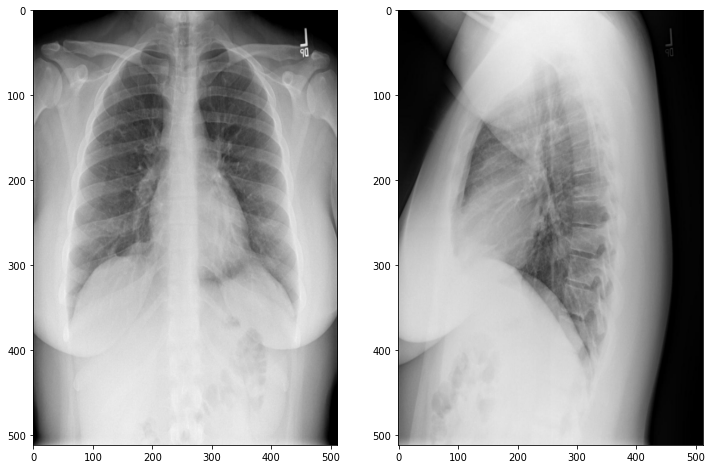


 Comparison:  nan

 Indication:  year old female with mid back pain that radiates to rib . recent injury .

 Findings:  pa and lateral radiograph the chest demonstrate stable cardiomediastinal silhouette . no focal consolidation large pleural effusion or pneumothorax is identified . evidence of prior granulomatous disease . visualized osseous structures appear intact .

 Impression:  no acute cardiopulmonary abnormality . 

 ****************************************************************************************************************************************************** 


2)



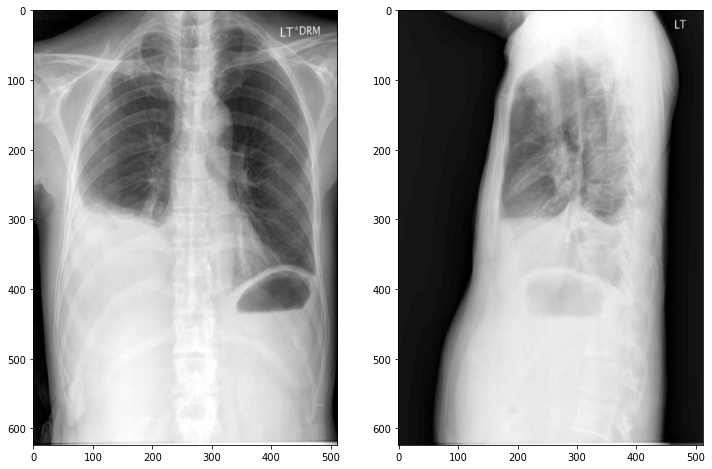


 Comparison:  pa and lateral views of the chest on ct scan of the thorax on

 Indication:  decreased oxygen saturation .

 Findings:  there has been interval development of a large right sided pleural effusion . the left lung is clear . there is no pneumothorax . heart size mediastinal contours are within normal limits . deformity is noted at the upper thoracic vertebral body .

 Impression:  interval development of large right sided pleural effusion . deformity noted at the upper thoracic vertebral body relates to deformity described on previous ct scan . 

 ****************************************************************************************************************************************************** 


3)



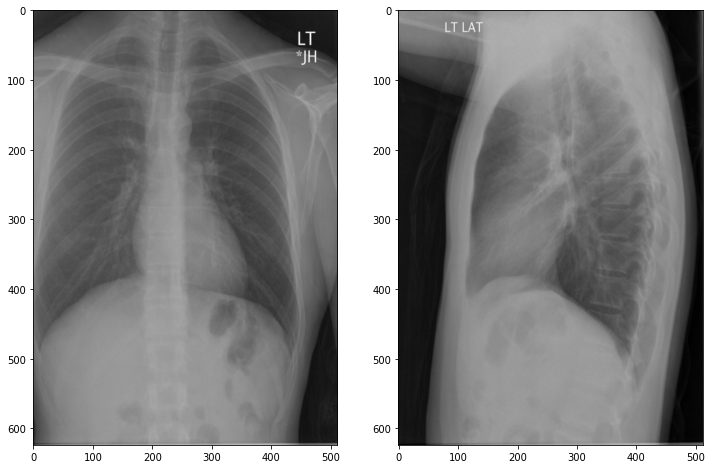


 Comparison:  none

 Indication:  syncope

 Findings:  and lateral chest examination was obtained . the heart silhouette is normal in size and contour . aortic appear unremarkable . lungs demonstrate no acute findings . there is no effusion or pneumothorax .

 Impression:  no acute pulmonary disease . 

 ****************************************************************************************************************************************************** 




In [38]:
#showing sample 3 datapoints
show_image_captions()

In [39]:
#getting wordclouds
#https://www.geeksforgeeks.org/generating-word-cloud-python/
temp = df.loc[:,'impression'].str.replace(".","").copy() #removing all fullstops and storing the result in a temp variable
words = ""
for i in temp.values:
  k = i.split()
  words+= " ".join(k) + " "
word = words.strip()
wc = WordCloud(width = 1024, height = 720, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 15,).generate(words) 

del k,words,temp

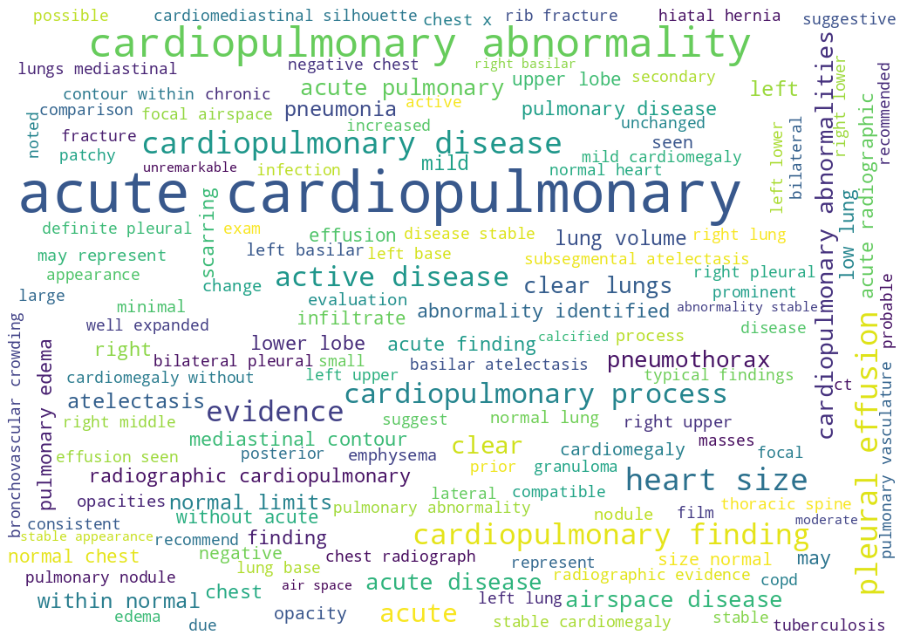

In [40]:
plt.figure(figsize = (16,16))
plt.imshow(wc)
plt.axis("off")
plt.show()


In [41]:
###encoder decoder starts here###

In [42]:
image_folder = '/cluster/home/guillera/varun/github_model_data/Images'
df_path = '/cluster/home/guillera/varun/medical_captioning/df_final.pkl'
chexnet_weights = '/cluster/home/guillera/varun/chexnet_weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'

In [44]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib #for saving model files as pkl files
import os
import seaborn as sns
import cv2
import imgaug.augmenters as iaa
sns.set(palette='muted',style='white')
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Input, Embedding, LSTM,Dot,Reshape,Concatenate,BatchNormalization, GlobalMaxPooling2D, Dropout, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu #bleu score
tf.compat.v1.enable_eager_execution()
import os
import math

In [45]:
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="false" #https://github.com/tensorflow/tensorflow/issues/33721#issuecomment-577307175


In [46]:
#ccreating tokenizer

In [53]:
df = pd.read_pickle(df_path)
col = ['image_1','image_2','impression','xml file name']
df = df[col].copy()
#path
df['image_1'] = df['image_1'].apply(lambda row: os.path.join(image_folder,row)) #https://stackoverflow.com/a/61880790
df['image_2'] = df['image_2'].apply(lambda row: os.path.join(image_folder,row))

df['impression_final'] = '<CLS> ' + df.impression + ' <END>'
df['impression_ip'] = '<CLS> ' + df.impression
df['impression_op'] = df.impression + ' <END>' 
print(df.shape)
df.head(2)


(4033, 7)


,image_1,image_2,impression,xml file name,impression_final,impression_ip,impression_op
0,/cluster/home/guillera/varun/github_model_data...,/cluster/home/guillera/varun/github_model_data...,no acute cardiopulmonary abnormalities .,2480.xml,<CLS> no acute cardiopulmonary abnormalities ....,<CLS> no acute cardiopulmonary abnormalities .,no acute cardiopulmonary abnormalities . <END>
1,/cluster/home/guillera/varun/github_model_data...,/cluster/home/guillera/varun/github_model_data...,large left hydropneumothorax with complete col...,1525.xml,<CLS> large left hydropneumothorax with comple...,<CLS> large left hydropneumothorax with comple...,large left hydropneumothorax with complete col...


In [54]:
df['impression'].value_counts()

no acute cardiopulmonary abnormality .                                                                                                                                                                                                                                                                                                                                                             383
no acute cardiopulmonary findings .                                                                                                                                                                                                                                                                                                                                                                172
no acute cardiopulmonary disease .                                                                                                                                                                                        

In [55]:
df.drop_duplicates(subset = ['xml file name'], inplace = True)

In [56]:
#adding a new column impression counts which tells the total value counts of impression of that datapoint 
k = df['impression'].value_counts()
df = df.merge(k,
         left_on = 'impression',
         right_index=True) #join left impression value with right index

df.columns


Index(['impression', 'image_1', 'image_2', 'impression_x', 'xml file name',
       'impression_final', 'impression_ip', 'impression_op', 'impression_y'],
      dtype='object')

In [57]:
df.columns = ['impression', 'image_1', 'image_2', 'impression_x', 'xml file name','impression_final',
       'impression_ip', 'impression_op', 'impression_counts'] #changin column names
del df['impression_x'] #deleting impression_x column
df.head()

,impression,image_1,image_2,xml file name,impression_final,impression_ip,impression_op,impression_counts
0,no acute cardiopulmonary abnormalities .,/cluster/home/guillera/varun/github_model_data...,/cluster/home/guillera/varun/github_model_data...,2480.xml,<CLS> no acute cardiopulmonary abnormalities ....,<CLS> no acute cardiopulmonary abnormalities .,no acute cardiopulmonary abnormalities . <END>,134
10,no acute cardiopulmonary abnormalities .,/cluster/home/guillera/varun/github_model_data...,/cluster/home/guillera/varun/github_model_data...,2286.xml,<CLS> no acute cardiopulmonary abnormalities ....,<CLS> no acute cardiopulmonary abnormalities .,no acute cardiopulmonary abnormalities . <END>,134
60,no acute cardiopulmonary abnormalities .,/cluster/home/guillera/varun/github_model_data...,/cluster/home/guillera/varun/github_model_data...,1684.xml,<CLS> no acute cardiopulmonary abnormalities ....,<CLS> no acute cardiopulmonary abnormalities .,no acute cardiopulmonary abnormalities . <END>,134
130,no acute cardiopulmonary abnormalities .,/cluster/home/guillera/varun/github_model_data...,/cluster/home/guillera/varun/github_model_data...,428.xml,<CLS> no acute cardiopulmonary abnormalities ....,<CLS> no acute cardiopulmonary abnormalities .,no acute cardiopulmonary abnormalities . <END>,134
139,no acute cardiopulmonary abnormalities .,/cluster/home/guillera/varun/github_model_data...,/cluster/home/guillera/varun/github_model_data...,2019.xml,<CLS> no acute cardiopulmonary abnormalities ....,<CLS> no acute cardiopulmonary abnormalities .,no acute cardiopulmonary abnormalities . <END>,134


In [58]:
from sklearn.model_selection import train_test_split
other1 = df[df['impression_counts']>5] #selecting those datapoints which have impression valuecounts >5
other2 = df[df['impression_counts']<=5] #selecting those datapoints which have impression valuecounts <=5
train,test = train_test_split(other1,stratify = other1['impression'].values,test_size = 0.1,random_state = 420)
test_other2_sample = other2.sample(int(0.2*other2.shape[0]),random_state = 420) #getting some datapoints from other2 data for test data
other2 = other2.drop(test_other2_sample.index,axis=0)
#here i will be choosing 0.5 as the test size as to create a reasonable size of test data
test = test.append(test_other2_sample)
test = test.reset_index(drop=True)

train = train.append(other2) 
train = train.reset_index(drop=True)
train.shape[0],test.shape[0]

(3257, 563)

In [60]:
from sklearn.utils import resample
df_majority = train[train['impression_counts']>=100] #having value counts >=100
df_minority = train[train['impression_counts']<=5] #having value counts <=5
df_other = train[(train['impression_counts']>5)&(train['impression_counts']<100)] #value counts between 5 and 100
n1 = df_minority.shape[0]
n2 = df_majority.shape[0]
n3 = df_other.shape[0]
#we will upsample them to 30
df_minority_upsampled = resample(df_minority,
                                 replace = True,
                                 n_samples = 3*n1,
                                 random_state = 420)
df_majority_downsampled = resample(df_majority,
                                 replace = False,
                                 n_samples = n2//15,
                                 random_state = 420)
df_other_downsampled = resample(df_other,
                                 replace = False,
                                 n_samples = n3//10,
                                 random_state = 420)

train = pd.concat([df_majority_downsampled ,df_minority_upsampled,df_other_downsampled])
train = train.reset_index(drop=True)
# del df_minority_upsampled,df_minority,df_majority,df_other,df_other_downsampled
train.shape

(13026, 8)

In [61]:
folder_name = '/cluster/home/guillera/varun/medical_captioning/pickle_files'
file_name = 'train.pkl'
train.to_pickle(os.path.join(folder_name,file_name))
file_name = 'test.pkl'
test.to_pickle(os.path.join(folder_name,file_name))

In [62]:
folder_name = '/cluster/home/guillera/varun/medical_captioning/pickle_files'
file_name = 'train.pkl'
train = pd.read_pickle(os.path.join(folder_name,file_name))

file_name = 'test.pkl'
test = pd.read_pickle(os.path.join(folder_name,file_name))

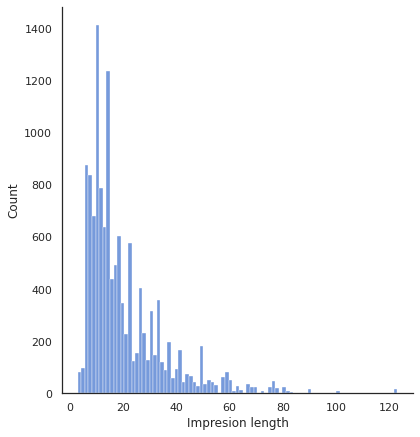


Value Counts for caption length top 5 values

Length|Counts
8     836
12    786
10    756
9     681
14    663
dtype: int64

The max and min value of "caption length" was found to be 123 and 3 respectively
The 80 percentile value of caption_len which is 30 will be taken as the maximum padded value for each impression


In [63]:
#tokenizer
tokenizer = Tokenizer(filters = '',oov_token = '<unk>') #setting filters to none
tokenizer.fit_on_texts(train.impression_final.values)
train_captions = tokenizer.texts_to_sequences(train.impression_final) 
test_captions = tokenizer.texts_to_sequences(test.impression_final) 
vocab_size = len(tokenizer.word_index)
caption_len = np.array([len(i) for i in train_captions])
start_index = tokenizer.word_index['<cls>'] #tokened value of <cls>
end_index = tokenizer.word_index['<end>'] #tokened value of <end>


#visualising impression length and other details
ax = sns.displot(caption_len,height = 6)
ax.set_titles('Value Counts vs Caption Length')
ax.set_xlabels('Impresion length')
plt.show()
print('\nValue Counts for caption length top 5 values\n')
print('Length|Counts')
print(pd.Series(caption_len).value_counts()[:5])
print('\nThe max and min value of "caption length" was found to be %i and %i respectively'%(max(caption_len),min(caption_len)))
print('The 80 percentile value of caption_len which is %i will be taken as the maximum padded value for each impression'%(np.percentile(caption_len,80)))
max_pad = int(np.percentile(caption_len,80))
del train_captions,test_captions #we will create tokenizing  and padding in-built in dataloader

In [64]:
batch_size = 100
embedding_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.2


In [65]:
class Dataset():
  #here we will get the images converted to vector form and the corresponding captions
  def __init__(self,df,input_size,tokenizer = tokenizer, augmentation = True,max_pad = max_pad): 
    """
    df  = dataframe containing image_1,image_2 and impression
    """
    self.image1 = df.image_1
    self.image2 = df.image_2
    self.caption = df.impression_ip #inp
    self.caption1 = df.impression_op  #output
    self.input_size = input_size #tuple ex: (512,512)
    self.tokenizer = tokenizer
    self.augmentation = augmentation
    self.max_pad = max_pad

    #image augmentation
    #https://imgaug.readthedocs.io/en/latest/source/overview/flip.html?highlight=Fliplr
    self.aug1 = iaa.Fliplr(1) #flip images horizaontally
    self.aug2 = iaa.Flipud(1) #flip images vertically


  def __getitem__(self,i):
    #gets the datapoint at i th index, we will extract the feature vectors of images after resizing the image  and apply augmentation
    image1 = cv2.imread(self.image1[i],cv2.IMREAD_UNCHANGED)/255 
    image2 = cv2.imread(self.image2[i],cv2.IMREAD_UNCHANGED)/255 #here there are 3 channels
    image1 = cv2.resize(image1,self.input_size,interpolation = cv2.INTER_NEAREST)
    image2 = cv2.resize(image2,self.input_size,interpolation = cv2.INTER_NEAREST)
    if image1.any()==None:
      print("%i , %s image sent null value"%(i,self.image1[i]))
    if image2.any()==None:
      print("%i , %s image sent null value"%(i,self.image2[i]))


    #tokenizing and padding
    caption = self.tokenizer.texts_to_sequences(self.caption[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    caption = pad_sequences(caption,maxlen = self.max_pad,padding = 'post') #opshape:(input_length,)
    caption = tf.squeeze(caption,axis=0) #opshape = (input_length,) removing unwanted axis if present

    caption1 = self.tokenizer.texts_to_sequences(self.caption1[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    caption1 = pad_sequences(caption1,maxlen = self.max_pad,padding = 'post') #opshape: (input_length,)
    caption1 = tf.squeeze(caption1,axis=0) #opshape = (input_length,) removing unwanted axis if present




    if self.augmentation: #we will not apply augmentation that crops the image 
          a = np.random.uniform()
          if a<0.333:
              image1 = self.aug1.augment_image(image1)
              image2 = self.aug1.augment_image(image2)
          elif a<0.667:
              image1 = self.aug2.augment_image(image1)
              image2 = self.aug2.augment_image(image2)
          else: #applying no augmentation
            pass;

    
    return image1,image2,caption,caption1

    
  def __len__(self):
    return len(self.image1)


class Dataloader(tf.keras.utils.Sequence):     #for batching
    def __init__(self, dataset, batch_size=1, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        indexes = [self.indexes[j] for j in range(start,stop)] #getting the shuffled index values
        data = [self.dataset[j] for j in indexes] #taken from Data class (calls __getitem__ of Data) here the shape is batch_size*3, (image_1,image_2,caption)
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)] #here the shape will become batch_size*input_size(of image)*3,batch_size*input_size(of image)*3
                                                                      #,batch_size*1*max_pad


        return tuple([[batch[0],batch[1],batch[2]],batch[3]]) #here [image1,image2, caption(without <END>)],caption(without <CLS>) (op)
    
    def __len__(self): #returns total number of batches in an epoch
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self): #it runs at the end of epoch
        if self.shuffle:
            np.random.shuffle(self.indexes) #in-place shuffling takes place

In [66]:
input_size = (224,224)
train_dataloader = Dataset(train,input_size)
train_dataloader = Dataloader(train_dataloader,batch_size = batch_size)

test_dataloader = Dataset(test,input_size)
test_dataloader = Dataloader(test_dataloader,batch_size = batch_size)

In [67]:
#chexnet weights ; https://drive.google.com/file/d/19BllaOvs2x5PLV_vlWMy4i8LapLb2j6b/view
def create_chexnet(chexnet_weights = chexnet_weights):
  """
  chexnet_weights: weights value in .h5 format of chexnet
  creates a chexnet model with preloaded weights present in chexnet_weights file
  """
  model = tf.keras.applications.DenseNet121(include_top=False) #importing densenet the last layer will be a relu activation layer

  #we need to load the weights so setting the architecture of the model as same as the one of tha chexnet
  x = model.output #output from chexnet
  x = GlobalAveragePooling2D()(x)
  x = Dense(14, activation="sigmoid", name="chexnet_output")(x) #here activation is sigmoid as seen in research paper

  chexnet = tf.keras.Model(inputs = model.input,outputs = x)
  chexnet.load_weights(chexnet_weights)
  chexnet = tf.keras.Model(inputs = model.input,outputs = chexnet.layers[-2].output)  #we will be taking the penultimate layer (second last layer here it is global avgpooling)
  return chexnet

In [69]:
chexnet = create_chexnet()
chexnet.trainable = False

tf.keras.utils.plot_model(
    chexnet,
    to_file="model_1.png",
    show_shapes=True,
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [70]:
del chexnet

In [71]:
#Simple encoder decoder model
#image encoder layer

In [72]:
class Image_encoder(tf.keras.layers.Layer):
  """
  This layer will output image backbone features after passing it through chexnet
  here chexnet will be not be trainable
  """
  def __init__(self,
               name = "image_encoder_block"
               ):
    super().__init__()
    self.chexnet = create_chexnet()
    self.chexnet.trainable = False
    # for i in range(10): #the last 10 layers of chexnet will be trained
    #   self.chexnet.layers[-i].trainable = True
    
  def call(self,data):
    op = self.chexnet(data)
    return op


In [73]:
#model

In [74]:
embedding_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.2

In [75]:
glove = {}
with open('/cluster/home/guillera/varun/glove.6B.300d.txt',encoding='utf-8') as f: #taking 300 dimesions
  for line in f:
    word = line.split() #it is stored as string like this "'the': '.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.4"
    glove[word[0]] = np.asarray(word[1:], dtype='float32')


embedding_dim = 300
# create a weight matrix for words in training docs for embedding purpose
embedding_matrix = np.zeros((vocab_size+1, embedding_dim)) #https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

for word, i in tokenizer.word_index.items():
  embedding_vector = glove.get(word)
  if embedding_vector is not None: #if the word is found in glove vectors
      embedding_matrix[i] = embedding_vector[:embedding_dim]


In [76]:
tf.keras.backend.clear_session()
image1 = Input(shape = (input_size + (3,))) #shape = 224,224,3
image2 = Input(shape = (input_size + (3,))) #https://www.w3resource.com/python-exercises/tuple/python-tuple-exercise-5.php
caption = Input(shape = (max_pad,))




img_encoder = Image_encoder() #contains chexnet model which is set trainable  =  False
# img2_encoder = Image_encoder() #opshape: (?,1024)
bk_feat1 = img_encoder(image1)
# bk_dense = Dense(dense_dim,
#                  activation = 'relu',
#                  name = 'bk_dense'
#                   )
# bk_feat1 = bk_dense(bk_feat1) #dense for the first image op: (?,dense_dim)

bk_feat2 = img_encoder(image2)
# bk_feat2 = bk_dense(bk_feat2) #dense for the 2nd image op: (?,dense_dim)

bk_features_concat = Concatenate(axis=-1)([bk_feat1,bk_feat2]) #concatenating the backbone images op_shape: (?,1024)
# bk_features_concat = BatchNormalization()(bk_features_concat) #applying batch norm
# bk_features_concat = Dropout(dropout_rate)(bk_features_concat) 
image_dense = Dense(dense_dim,
                    activation = 'relu',
                    name = 'Image_dense',
                    use_bias='False'

                    )

                    
image_bkbone = image_dense(bk_features_concat) #final op from dense op_shape: (?,dense_dim) this will be added as initial states to the lstm
image_dense_op = tf.keras.backend.expand_dims(image_bkbone,axis=1) #op_shape: (?,1,dense_dim)



embedding = Embedding(input_dim  = vocab_size+1,
                              output_dim = embedding_dim,
                              input_length = max_pad,
                              mask_zero = True,
                              weights = [embedding_matrix],
                              name = 'embedding'
                              )
embed_op = embedding(caption) #op_shape: (?,input_length,embedding_dim)






lstm_layer = LSTM(units = lstm_units,
                  return_sequences= True,
                  return_state = True     
                  )
lstm_op,lstm_h,lstm_c = lstm_layer(embed_op,initial_state = [image_bkbone,image_bkbone]) #op_shape = batch_size*input_length*lstm_units

# lstm_op = BatchNormalization()(lstm_op)
add = Add()([image_dense_op,lstm_op]) #op_shape: (?,input_lenght,lstm_units/dense_dim) here lstm_dims=dense_dim

op_dense = Dense(vocab_size+1,
                 activation = 'softmax',
                 name = 'output_dense'
                 ) #op: (?,input_length,vocab_size+1)

output = op_dense(add)

model = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)

In [77]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
image_encoder (Image_encoder)   (None, 1024)         7037504     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 2048)         0           image_encoder[0][0]        

In [78]:
tf.keras.utils.plot_model(model,
                          show_shapes = True
                          )

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [79]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy() 

def custom_loss(y_true, y_pred):
    #getting mask value to not consider those words which are not present in the true caption
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))

    #y_pred = y_pred+10**-7 #to prevent loss becoming null

    #calculating the loss
    loss_ = loss_func(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #returning mean over all the values
    return tf.reduce_mean(loss_)

lr = 10**-3
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)   
model.compile(optimizer=optimizer,loss=custom_loss,metrics= ['accuracy'])

In [80]:
tf.keras.backend.clear_session()
tb_filename = 'Simple_Encoder_Decoder/'
tb_file = os.path.join('/cluster/home/guillera/varun',tb_filename)
model_filename = 'Simple_Encoder_Decoder.h5'
model_save = os.path.join('/cluster/home/guillera/varun',model_filename)
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 5,
                                     verbose = 2
                                     ),
    tf.keras.callbacks.ModelCheckpoint(filepath=model_save,
                                       save_best_only = True,
                                      save_weights_only = True,
                                       verbose = 2
                                       ),
    tf.keras.callbacks.TensorBoard(histogram_freq=1,
                                   log_dir=tb_file),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=10**-7, verbose = 2)
                                   
] #from keras documentation

In [81]:
!rm -r '/cluster/home/guillera/varun/Simple_Encoder_Decoder/'

rm: cannot remove '/cluster/home/guillera/varun/Simple_Encoder_Decoder/': No such file or directory


In [82]:


model.fit(train_dataloader,
          validation_data = test_dataloader,
          epochs = 10,
          callbacks = my_callbacks
          )



Epoch 1/10
130/130 [==============================] - 409s 3s/step - loss: 0.8177 - accuracy: 0.1978 - val_loss: 0.3820 - val_accuracy: 0.3463

Epoch 00001: val_loss improved from inf to 0.38201, saving model to /cluster/home/guillera/varun/Simple_Encoder_Decoder.h5
Epoch 2/10
130/130 [==============================] - 401s 3s/step - loss: 0.4124 - accuracy: 0.4899 - val_loss: 0.2939 - val_accuracy: 0.4049

Epoch 00002: val_loss improved from 0.38201 to 0.29389, saving model to /cluster/home/guillera/varun/Simple_Encoder_Decoder.h5
Epoch 3/10
130/130 [==============================] - 407s 3s/step - loss: 0.2525 - accuracy: 0.6808 - val_loss: 0.3302 - val_accuracy: 0.4202

Epoch 00003: val_loss did not improve from 0.29389
Epoch 4/10
130/130 [==============================] - 409s 3s/step - loss: 0.1750 - accuracy: 0.7800 - val_loss: 0.3765 - val_accuracy: 0.4104

Epoch 00004: val_loss did not improve from 0.29389

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.000100000004

In [85]:
model_filename = 'Simple_Encoder_Decoder.h5'
model_save = os.path.join('/cluster/home/guillera/varun',model_filename)
model1 = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)
model1.load_weights(model_save)

In [86]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [87]:
%reload_ext tensorboard

In [88]:
%tensorboard --logdir '/cluster/home/guillera/varun'


ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 2596706.

In [89]:
#Predictions

In [90]:
def get_bleu(reference,prediction):
  """
  Given a reference and prediction string, outputs the 1-gram,2-gram,3-gram and 4-gram bleu scores
  """
  reference = [reference.split()] #should be in an array (cos of multiple references can be there here only 1)
  prediction = prediction.split()
  bleu1 = sentence_bleu(reference,prediction,weights = (1,0,0,0),)
  bleu2 = sentence_bleu(reference,prediction,weights = (0.5,0.5,0,0))
  bleu3 = sentence_bleu(reference,prediction,weights = (0.33,0.33,0.33,0))
  bleu4 = sentence_bleu(reference,prediction,weights = (0.25,0.25,0.25,0.25))

  return bleu1,bleu2,bleu3,bleu4


In [91]:
#calculate bleu scores for every datapoint
def mean_bleu(test,predict,model=model1,**kwargs):
  """
  given a df and predict fucntion which predicts the impression of the caption
  outpus the mean bleu1,bleu2,bleu3, bleu4 for entire datapoints in df
  """
  if kwargs!=None:
    top_k = kwargs.get('top_k')
  else:
    top_k = None
  bleu1,bleu2,bleu3,bleu4 = [],[],[],[]
  for index,data in test.iterrows():
    if top_k==None:
      predict_val = predict(data['image_1'],data['image_2'],model = model) #predicted sentence
    else:
      predict_val = predict(data['image_1'],data['image_2'],model = model,top_k = top_k)
    true = data.impression
    _ = get_bleu(true,predict_val)
    bleu1.append(_[0])
    bleu2.append(_[1])
    bleu3.append(_[2])
    bleu4.append(_[3])
  return np.array(bleu1).mean(),np.array(bleu2).mean(),np.array(bleu3).mean(),np.array(bleu4).mean()


In [92]:
#Greedy Search

In [93]:
def greedy_search_predict(image1,image2,model = model1):
  """
  Given paths to two x-ray images predicts the impression part of the x-ray in a greedy search algorithm
  """
  image1 = cv2.imread(image1,cv2.IMREAD_UNCHANGED)/255 
  image2 = cv2.imread(image2,cv2.IMREAD_UNCHANGED)/255 
  image1 = tf.expand_dims(cv2.resize(image1,input_size,interpolation = cv2.INTER_NEAREST),axis=0) #introduce batch and resize
  image2 = tf.expand_dims(cv2.resize(image2,input_size,interpolation = cv2.INTER_NEAREST),axis=0)
  

  image1 = model.get_layer('image_encoder')(image1) #output from chexnet
  image2 = model.get_layer('image_encoder')(image2)

  # image1 = model.get_layer('bk_dense')(image1) #op from dense layer
  # image2 = model.get_layer('bk_dense')(image2)

  concat = model.get_layer('concatenate')([image1,image2])
  image_dense = model.get_layer('Image_dense')(concat)
  # concat = model.get_layer('batch_normalization')(concat)
  # image_dense = model.get_layer('Image_dense')(concat)
  bk_feat = tf.keras.backend.expand_dims(image_dense,axis=1)


  states = [image_dense, image_dense]
  a = []
  pred = []
  for i in range(max_pad):
    if i==0: #if first word
      caption = np.array(tokenizer.texts_to_sequences(['<cls>'])) #shape: (1,1)
    caption= model.get_layer('embedding')(caption) #embedding shape = 1*1*300
    caption,state_h,state_c = model.get_layer('lstm')(caption,initial_state = states) #lstm 1*1*512
    states = [state_h,state_c]

    add = model.get_layer('add')([bk_feat,caption]) #add
    output = model.get_layer('output_dense')(add) #1*1*vocab_size (here batch_size=1)

    #prediction
    max_prob = tf.argmax(output,axis=-1) #tf.Tensor of shape = (1,1)
    caption = np.array(max_prob) #will be sent to embedding for next iteration
    if max_prob==np.squeeze(tokenizer.texts_to_sequences(['<end>'])): 
      break;
    else:
      a.append(tf.squeeze(max_prob).numpy())
  return tokenizer.sequences_to_texts([a])[0] #here output would be 1,1 so subscripting to open the array

In [94]:
%%time
k=-1
image1,image2 = test['image_1'].iloc[k],test['image_2'].iloc[k]
print(greedy_search_predict(image1,image2,model=model))

no acute cardiopulmonary abnormality <unk> right upper lobe anterior anterior h rib . <unk> right fracture . <unk> right shoulder . <unk> right shoulder . <unk> right shoulder . <unk>
CPU times: user 1.35 s, sys: 202 ms, total: 1.55 s
Wall time: 3.72 s


In [95]:
%%time
_ = mean_bleu(test,greedy_search_predict)

CPU times: user 11min 39s, sys: 1min 12s, total: 12min 52s
Wall time: 6min 47s


In [97]:
k = list(_)
index = 'greedy search'
result = pd.DataFrame([k],columns = ["bleu1","bleu2","bleu3","bleu4"],index = [index])

In [98]:
result

,bleu1,bleu2,bleu3,bleu4
greedy search,0.122158,0.05867,0.032868,0.014301


In [99]:
def encoder_op(image1,image2,model = model1):
  """
  Given image1 and image2 filepath, outputs
  their backbone features which will be input
  to the decoder
  """
  image1 = cv2.imread(image1,cv2.IMREAD_UNCHANGED)/255 
  image2 = cv2.imread(image2,cv2.IMREAD_UNCHANGED)/255

  image1 = tf.expand_dims(cv2.resize(image1,input_size,interpolation = cv2.INTER_NEAREST),axis=0) #introduce batch and resize
  image2 = tf.expand_dims(cv2.resize(image2,input_size,interpolation = cv2.INTER_NEAREST),axis=0)

  image1 = model.get_layer('image_encoder')(image1) #output from chexnet
  image2 = model.get_layer('image_encoder')(image2)

  concat = model.get_layer('concatenate')([image1,image2])
  image_dense = model.get_layer('Image_dense')(concat)
  bk_feat = tf.keras.backend.expand_dims(image_dense,axis=1)
  states = [image_dense, image_dense]
  return bk_feat,states

In [100]:
def beam_search_predict(image1,image2,top_k=3,max_pad = max_pad,model = model1):
  """
  Given image1, image2 get the top
  beam search predicted sentence
  """
  k = top_k
  cls_token = tokenizer.texts_to_sequences(['<cls>'])[0] #[3]
  bk_feat,states = encoder_op(image1,image2)
  seq_score = [[cls_token,0,states]] #[[[3], 0]]
  finished_seq_score = []
  for i in range(max_pad): #traverse through all lengths
    all_candidates = [] #stores all the top k seq along with their scores
    new_seq_score = [] #stores the seq_score which does not have <end> in them
    for s in seq_score: #traverse for all top k sequences
      text_input = s[0][-1] #getting the last predicted output
      # print(s)
      states = s[2]
      caption = model.get_layer('embedding')(np.array([[text_input]])) #ip must be in shape (batch_size,seq length,dim)
      caption,state_h,state_c = model.get_layer('lstm')(caption,initial_state = states)
      states = [state_h,state_c]
      add = model.get_layer('add')([bk_feat,caption])
      output = model.get_layer('output_dense')(add)[0][0] #(vocab_size,)
      top_words = tf.argsort(output,direction = 'DESCENDING')[:k] #get the top k words

      seq,score,_ = s
      for t in top_words.numpy():
        #here we will update score with log of probabilities and subtracting(log of prob will be in negative)
        #here since its -(log), lower the score higher the prob
        candidates = [seq+[t],score-np.log(output[t].numpy()),states] #updating the score and seq
        all_candidates.append(candidates)
      seq_score = sorted(all_candidates,key = lambda l:l[1])[:k] #getting the top 3 sentences with high prob ie low score
      #checks for  <end> in each seq obtained
      count = 0
      end_token = tokenizer.word_index['<end>']
      for seq,score,state in seq_score:
        # print('seq,score',seq,score)
        if seq[-1] == end_token: #if last word of the seq is <end>
          finished_seq_score.append([seq,score])
          count+=1
        else:
          new_seq_score.append([seq,score,state])
      k-=count #substracting the no. of finished sentences from beam length
      seq_score = new_seq_score

      if seq_score==[]: #if null array
        break;
      else:
        continue;

  seq_score = finished_seq_score[-1]
  sentence = seq_score[0][1:-1] #here <cls> and <end> is here so not considering that
  score = seq_score[1]
      
  return tokenizer.sequences_to_texts([sentence])[0]